# Create gridded feature datasets

The goal here is to take the spatio-temporally harmonised files in `interim/` that were output from `1_Spatiotemporal_harmonization.ipynb` and stack them into ready-to-use netcdf files in the `5km` data folder. We want one netcdf per feature. Additionally, we create a few new features, for example vegetation fractions and climate anomalies etc.


In [1]:
import os
import pandas as pd
import xarray as xr
import rioxarray as rxr
import numpy as np
from odc.geo.xr import assign_crs

import warnings
warnings.simplefilter(action='ignore')

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import start_local_dask

In [2]:
client = start_local_dask(mem_safety_margin='2Gb')
client

distributed.nanny.memory - WARNING - Ignoring provided memory limit 200453475328 due to system memory limit of 95.00 GiB
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configurati

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46239/status,
Dashboard: /proxy/46239/status,Workers: 1
Total threads: 24,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34373,Workers: 1
Dashboard: /proxy/46239/status,Total threads: 24
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:37117,Total threads: 24
Dashboard: /proxy/44771/status,Memory: 95.00 GiB
Nanny: tcp://127.0.0.1:36511,


In [3]:
base = '/g/data/os22/chad_tmp/AusEFlux/data/interim/'
results='/g/data/os22/chad_tmp/AusEFlux/data/5km/'

#any datasets in interim we want to exclude?
exclude = ['.ipynb_checkpoints', 'kTavg', 'Tmax', 'Tmin']

## Loop through folders and join interim files

In [ ]:
folders = [i for i in os.listdir(base) if i not in exclude]
folders.sort()

for f in folders:
    
    if os.path.exists(results+f+'_5km_2003_2022.nc'):
        print('','skipping '+f)
        continue
    else:
        print(f)
    
    files = [f'{base}{f}/{i}' for i in os.listdir(base+f) if i.endswith(".nc")]
    files.sort()

    #combine annual files into one file
    ds = xr.open_mfdataset(files)
    ds = ds.chunk(dict(time=-1, latitude=250, longitude=250))
                  
    # Gapfill NDWI differently (has real gaps)
    if f=='NDWI':
        # seperate into climatologies and anomalies
        ds_monthly = ds.groupby('time.month').mean()
        ds_anom = ds.groupby('time.month') - ds_monthly  
        
        # fill linearly by max 2 steps
        ds_anom = ds_anom.interpolate_na(dim='time', method='linear', limit=2)
        
        #recombine anomalies and climatology
        ds = ds_anom.groupby('time.month') + ds_monthly
        ds = ds.drop('month')
        
        #fill remaining gaps with climatology
        ds = ds.groupby("time.month").fillna(ds_monthly)

    # ensure no gaps in other datasets (there shouldn't be any)
    # this is just to be cautious
    else:
        ds_monthly = ds.groupby('time.month').mean()
        ds = ds.groupby("time.month").fillna(ds_monthly)
    
    ds = ds.drop('month').compute()

    ds.to_netcdf(results+f+'_5km_2003_2022.nc')

In [4]:
new_ndwi = xr.open_dataarray('/g/data/os22/chad_tmp/AusEFlux/data/5km/NDWI_5km_2003_2022.nc')

In [12]:
old_ndwi = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/NDWI_1km_monthly_2002_2022.nc')

In [9]:
import matplotlib.pyplot as plt

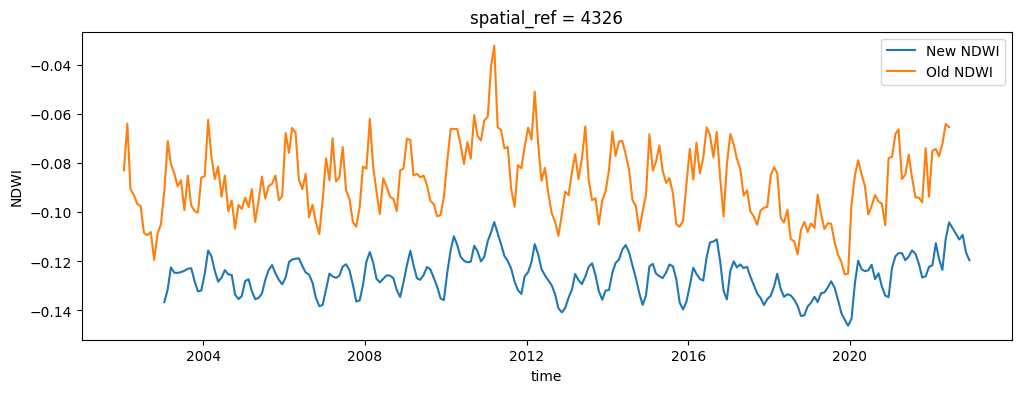

In [13]:
fig,ax = plt.subplots(1,1, figsize=(12,4))
new_ndwi.mean(['latitude','longitude']).plot(ax=ax, label='New NDWI')
old_ndwi.mean(['latitude','longitude']).plot(ax=ax, label='Old NDWI')
ax.legend()

## Create new features

Using the climate and remote-sensing features we've already collected, we can generate new features

### Vegetation fractions (Trees, Grass, Bare)

Following [Donohue 2009](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2486.2008.01746.x)

This uses NDVI, not EVI

In [ ]:
# NDVI value of bare soil (supplied by Luigi Renzullo)
ndvi_min = xr.open_dataarray('/g/data/os22/chad_tmp/AusEFlux/data/ndvi_of_baresoil_5km.nc',
                            chunks=dict(latitude=250, longitude=250)
                            )

# likely maximum possible NDVI
ndvi_max = 0.91

#ndvi data is here
ndvi_path = '/g/data/os22/chad_tmp/AusEFlux/data/5km/NDVI_5km_2003_2022.nc'
ds = xr.open_dataarray(ndvi_path, chunks=dict(time=-1, latitude=250, longitude=250))

In [ ]:
#calculate f-total
ft = (ds - ndvi_min) / (ndvi_max - ndvi_min)
ft = xr.where(ft<0, 0, ft)
ft = xr.where(ft>1, 1, ft)

#calculate initial persistent fraction (equation 1 & 2 in Donohue 2009)
persist = ft.rolling(time=7, min_periods=1).min()
persist = persist.rolling(time=9, min_periods=1).mean()

#calculate initial recurrent fraction (equation 3 in Donohue 2009)
recurrent = ft - persist

###------- equations 4 & 5 in Donohue 2009----------------
persist = xr.where(recurrent<0, persist - np.abs(recurrent), persist) #eq4
recurrent = ft - persist # eq 5
## ---------------------------------------------------------

#ensure values are between 0 and 1
persist = xr.where(persist<0, 0, persist)
recurrent = xr.where(recurrent<0, 0, recurrent)

#assign variable names
recurrent.name='grass'
persist.name='trees'

#### Aggregate to annual layers

Use the maximum fraction of trees and grass to create annual layers.

Bare soil is the residual

In [ ]:
persist_annual = persist.resample(time='1Y').max().compute()
recurrent_annual = recurrent.resample(time='1Y').max().compute()
bare_annual = 1-(persist_annual+recurrent_annual)
bare_annual.name='bare'

#### Create monthly timeseries

In [ ]:
dss_trees=[]
dss_grass=[]
dss_bare=[]
for y in bare_annual.time.dt.year.values:
    # print(y)
    y = str(y)
    time = pd.date_range(y+"-01", y+"-12", freq='MS') 
    time = [t+pd.Timedelta(14, 'd') for t in time]

    #trees
    ds_persist = persist_annual.sel(time=y).squeeze().drop('time')
    ds_persist = ds_persist.expand_dims(time=time)
    dss_trees.append(ds_persist)

    #grass
    ds_recurrent = recurrent_annual.sel(time=y).squeeze().drop('time')
    ds_recurrent = ds_recurrent.expand_dims(time=time)
    dss_grass.append(ds_recurrent)

    ds_bare = bare_annual.sel(time=y).squeeze().drop('time')
    ds_bare = ds_bare.expand_dims(time=time)
    dss_bare.append(ds_bare)

# join all the datasets back together
trees = xr.concat(dss_trees, dim='time').sortby('time')
grass = xr.concat(dss_grass, dim='time').sortby('time')
bare = xr.concat(dss_bare, dim='time').sortby('time')

# add right metadata
trees.attrs['nodata'] = np.nan
grass.attrs['nodata'] = np.nan
bare.attrs['nodata'] = np.nan

trees = assign_crs(trees, crs='EPSG:4326')
grass = assign_crs(grass, crs='EPSG:4326')
bare = assign_crs(bare, crs='EPSG:4326')


#### Export data

In [ ]:
trees.to_netcdf(results+'trees_5km_2003_2022.nc')
grass.to_netcdf(results+'grass_5km_2003_2022.nc')
bare.to_netcdf(results+'bare_5km_2003_2022.nc')

### Cumulative rainfall

In [ ]:
rain = xr.open_dataarray(results+'rain_5km_2003_2022.nc',chunks=dict(latitude=300, longitude=300))

In [ ]:
rain_cml_3 = rain.rolling(time=3, min_periods=3).sum()
rain_cml_3 = rain_cml_3.rename('rain_cml3').sel(time=slice('2003','2022'))

rain_cml_6 = rain.rolling(time=6, min_periods=6).sum()
rain_cml_6 = rain_cml_6.rename('rain_cml6').sel(time=slice('2003','2022'))

rain_cml_12 = rain.rolling(time=12, min_periods=12).sum()
rain_cml_12 = rain_cml_12.rename('rain_cml12').sel(time=slice('2003','2022'))

In [ ]:
rain_cml_3.compute().to_netcdf(results+'rain_cml3_5km_2003_2022.nc')
rain_cml_6.compute().to_netcdf(results+'rain_cml6_5km_2003_2022.nc')
rain_cml_12.compute().to_netcdf(results+'rain_cml12_5km_2003_2022.nc')

In [ ]:
# rain_cml_12.mean(['latitude', 'longitude']).plot(figsize=(11,4))

### Fractional climate anomalies

fractional anomalies = obs / climatology (climatology goes from 2003-2022)

In [ ]:
#vars for which we will calculate frcational anomalies
vars = ['NDWI','EVI', 'rain', 'rain_cml3', 'rain_cml6', 'rain_cml12', 'SRAD', 'Tavg', 'VPD']

for v in vars:
    print(v)
    ds = assign_crs(xr.open_dataset(results+v+'_5km_2003_2022.nc'), crs='EPSG:4326')
    mean = ds.groupby("time.month").mean("time")
    frac = ds.groupby("time.month") / mean
    frac.drop('month').rename({v:v+'_anom'}).to_netcdf(results+v+'_anom_5km_2003_2022.nc')
    break

## LST - Tair

In [ ]:
tair = xr.open_dataarray(results+'Tavg_5km_2003_2022.nc')

lst = xr.open_dataarray(results+'LST_5km_2003_2022.nc')

deltaT = lst - tair
deltaT.name = u'ΔT'

In [ ]:
deltaT.to_netcdf(results+u'ΔT_5km_2003_2022.nc')

In [ ]:
# deltaT.mean(['latitude', 'longitude']).plot(figsize=(11,4))